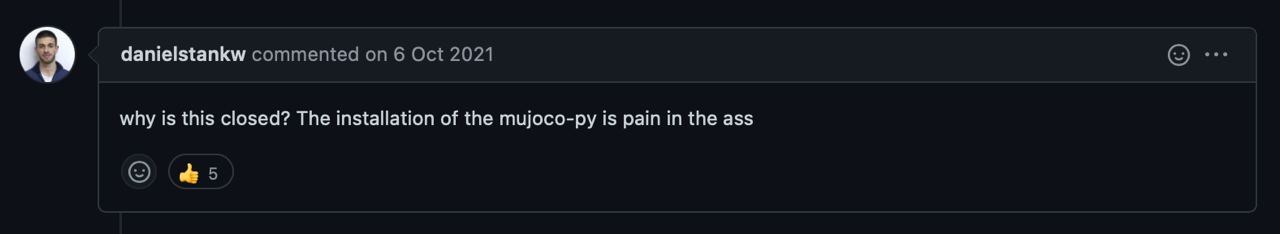

In [49]:
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as accuracy
from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import trange, tqdm
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
import time

In [2]:
geyser = pd.read_csv('./data/geyser.csv')
chip = pd.read_csv('./data/chips.csv')

In [3]:
def to_sign(ds):
    ds['class'].loc[ds['class'] == 'N'] = -1
    ds['class'].loc[ds['class'] == 'P'] = 1

to_sign(geyser)
to_sign(chip)
chip.head()

/home/masha/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,x,y,class
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
def to_x_y(ds):
    return ds.drop('class', axis=1).values, ds['class'].values

# Kernels

In [5]:
def linear(_):
    def kernel(x, y):
        return jnp.matmul(jnp.transpose(x), y)
    return kernel

def polynomial(d=1):
    def kernel(x, y):
        return (jnp.matmul(jnp.transpose(x), y) + 1)**d
    return kernel

def gaussian(sigma_squared=1):
    def kernel(x, y):
        return jnp.exp(- linear(_)(jnp.subtract(x, y), jnp.subtract(x, y))**2)
    return kernel

In [6]:
l = linear(None)
poly = polynomial()
gauss = gaussian()
print(f"Linear: {l(chip['x'].values, chip['y'].values)}, Polynomial: {poly(chip['x'].values, chip['y'].values)}, Gaussian: {gauss(chip['x'].values, chip['y'].values)}")

Linear: -3.005676746368408, Polynomial: -2.005676746368408, Gaussian: 0.0


# [Nice SVM with SMO NO BUGS](https://www.microsoft.com/en-us/research/uploads/prod/1998/04/sequential-minimal-optimization.pdf)

In [7]:
def svm(xs, ys, alphas, kernel, b):
    def solve(x_dot):
        return b + sum([alpha * y * kernel(x, x_dot) for (alpha, y, x) in zip(alphas, ys, xs)])
    return solve

def to_class(svm, x):
    return [int(p) for p in jnp.sign(jnp.array([svm(x_dot) for x_dot in x]))]

In [8]:
# sequential minimal optimization
def smo(xs, ys, kernel, c, steps=1, eps=1e-5, seed=0):
    b = 0
    alphas = jnp.zeros(xs.shape[0])
    
    def optimize(i1, i2):
        nonlocal b
        nonlocal alphas
        
        if i1 == i2:
            return False
        
        x1, x2 = xs[i1], xs[i2]
        alpha1, alpha2 = alphas[i1], alphas[i2]
        y1, y2 = ys[i1], ys[i2]
        cur_svm = svm(xs, ys, alphas, kernel, b)
        e1 = svm(xs, ys, alphas, kernel, b)(x1) - y1
        
        if not (y1 * e1 < - eps and alpha1 < c or y1 * e1 > eps and alpha1 > 0):
            return False
        
        e2 = svm(xs, ys, alphas, kernel, b)(x2) - y2
        s = y1 * y2
        
        if y1 == y2:
            l = max(0, alpha2 + alpha1 - c)
            h = min(c, alpha2 + alpha1)
        else:
            l = max(0, alpha2 - alpha1)
            h = min(c, c + alpha2 - alpha1)
            
        if abs(l - h) < eps:
            return False
        
        k11 = kernel(x1, x1)
        k12 = kernel(x1, x2)
        k22 = kernel(x2, x2)
        
        eta = - (k11 + k22 - 2 * k12)
        
        if eta >= 0:
            return False
        
        a2 = alpha2 - y2 * (e1 - e2) / eta
        if a2 < l:
            a2 = l
        elif a2 > h:
            a2 = h
        
        if abs(a2 - alpha2) < eps:
            return False
        
        a1 = alpha1 + s * (alpha2 - a2)
        
        # update threshold
        b1 = b - e1 - y1 * (a1 - alpha1) * k11 - y2 * (a2 - alpha2) * k12
        b2 = b - e2 - y1 * (a1 - alpha1) * k12 - y2 * (a2 - alpha2) * k22
        
        if 0 < a1 and a1 < c:
            b = b1
        elif 0 < a2 and a2 < c:
            b = b2
        else:
            b = (b1 + b2) / 2
            
        alphas = alphas.at[i1].set(a1)
        alphas = alphas.at[i2].set(a2)
        return True
    
    key = jax.random.PRNGKey(seed)
    for step in range(steps):
        for i in range(len(ys)):
            j = jax.random.randint(key, (1,), 0, len(xs) - 1)[0]
            key = jax.random.split(key, num=1)[0]
            optimized = optimize(i, j)
            
    return svm(xs, ys, alphas, kernel, b), (alphas, b)

# Nice hyperparams

In [9]:
def find_hyperparams(data, cs, kernel_stuff):
    kernels, kernel_args = kernel_stuff
    x, y = data
    kf = KFold(n_splits=3)
    best_results = {kernel: {'accuracy': 0} for kernel in kernels}
    for c in tqdm(cs):
        for (kernel, args) in zip(kernels, kernel_args):
            print(f'Kernel: {kernel}')
            for arg in args:
                acc = 0
                for train_index, test_index in kf.split(x):
                    train_index = jnp.array(train_index)
                    test_index = jnp.array(test_index)
                    x_train, y_train = x.take(train_index), y.take(train_index)
                    x_test, y_test = x.take(test_index), y.take(test_index)
                    nice_svm, _ = smo(x_train, y_train, kernel(arg), c=c, steps=1)
                    predictions = to_class(nice_svm, x_test)
                    acc += accuracy(predictions, y_test)
                acc /= kf.get_nb_splits(x)
                if acc > best_results[kernel]['accuracy']:
                    best_results[kernel]['accuracy'] = acc
                    best_results[kernel]['kernel_args'] = arg
                    best_results[kernel]['c'] = c
            print('------Best accuracy: ', best_results[kernel]['accuracy'])
    return best_results

In [10]:
kernels = (linear, polynomial, gaussian)
kernel_args = ((None,), (2, 3, 5), (1, 2, 5))
c = (0.1, 1, 100)

# Visualization

In [11]:
COLORS = ('blue', 'yellow', 'red')

def plot_svm(svm, min_y=0, min_x=0, max_y=5, max_x=25):
    xs = []
    for i in jnp.linspace(min_y, max_y, num=10):
        js = jnp.linspace(min_x, max_x, num=50)
        xs = xs + [jnp.array([j, i]) for j in js]
    y = to_class(svm, xs)
    plot_something(xs, y)
    
def plot_svm_solution(svm, x, y):
    prediction = to_class(svm, x)
    for (x_dot, y_true, pred) in zip(x, y, prediction):
        plt.scatter(*x_dot, color=COLORS[2 if not y_true == pred else max(0, y_true)])
    plt.show()
    
def plot_something(x, y):
    for (x_dot, y_dot) in zip(x, y):
        plt.scatter(*x_dot, color=COLORS[max(0, y_dot)])
    plt.show()

## Geyser

In [12]:
x, y = to_x_y(geyser)
y = y.astype(jnp.integer)

/tmp/ipykernel_2446884/126357050.py:3: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y_test = y_test.astype(jnp.integer)


In [14]:
best_params = find_hyperparams((x, y), c, (kernels, kernel_args))
best_params

  0%|          | 0/3 [00:00<?, ?it/s]

Kernel: <function linear at 0x7fdc67fc2940>
------Best accuracy:  0.8444444444444444
Kernel: <function polynomial at 0x7fdc67fc29d0>
------Best accuracy:  0.7777777777777778
Kernel: <function gaussian at 0x7fdc67fc2a60>
------Best accuracy:  0.8
Kernel: <function linear at 0x7fdc67fc2940>
------Best accuracy:  0.8888888888888888
Kernel: <function polynomial at 0x7fdc67fc29d0>
------Best accuracy:  0.7777777777777778
Kernel: <function gaussian at 0x7fdc67fc2a60>
------Best accuracy:  0.8888888888888888
Kernel: <function linear at 0x7fdc67fc2940>
------Best accuracy:  0.8888888888888888
Kernel: <function polynomial at 0x7fdc67fc29d0>
------Best accuracy:  0.7777777777777778
Kernel: <function gaussian at 0x7fdc67fc2a60>
------Best accuracy:  0.8888888888888888


{<function __main__.linear(_)>: {'accuracy': 0.8888888888888888,
  'kernel_args': None,
  'c': 1},
 <function __main__.polynomial(d=1)>: {'accuracy': 0.7777777777777778,
  'kernel_args': 2,
  'c': 0.1},
 <function __main__.gaussian(sigma_squared=1)>: {'accuracy': 0.8888888888888888,
  'kernel_args': 1,
  'c': 1}}

### Linear

In [15]:
x, y = to_x_y(geyser)
best_linear, linear_params = smo(x, y, kernel=linear(_), c=1)

In [16]:
f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_linear, x))}'

/tmp/ipykernel_2446884/2966238524.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_linear, x))}'


'Accuracy 0.8603603603603603'

#### Decision region

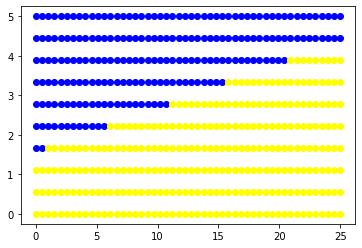

In [17]:
plot_svm(best_linear)

#### SVM classification & errors

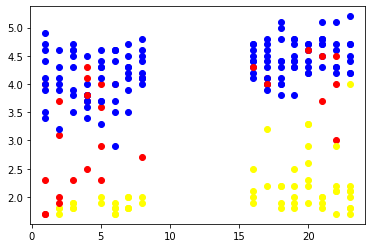

In [18]:
plot_svm_solution(best_linear, x, y)

#### Real data

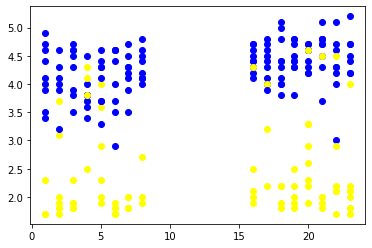

In [19]:
plot_something(x, y)

### Polynomial

In [22]:
x, y = to_x_y(geyser)
best_poly, poly_params = smo(x, y, kernel=polynomial(2), c=.1)

In [23]:
f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_poly, x))}'

/tmp/ipykernel_2446884/1926486611.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_poly, x))}'


'Accuracy 0.7612612612612613'

#### Decision regions

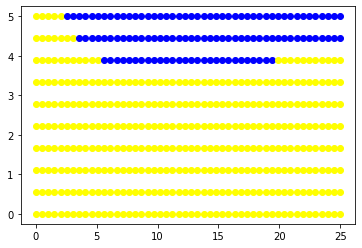

In [24]:
plot_svm(best_poly)

#### SVM predictions & errors

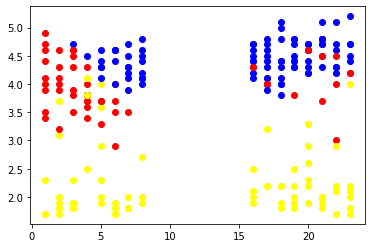

In [25]:
plot_svm_solution(best_poly, x, y)

#### Real data

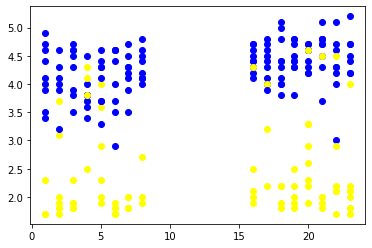

In [26]:
plot_something(x, y)

### Gaussian

In [27]:
x, y = to_x_y(geyser)
best_gauss, _ = smo(x, y, kernel=gaussian(1), c=1)

In [28]:
f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_gauss, x))}'

/tmp/ipykernel_2446884/1674753320.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_gauss, x))}'


'Accuracy 0.8873873873873874'

#### Decision Regions

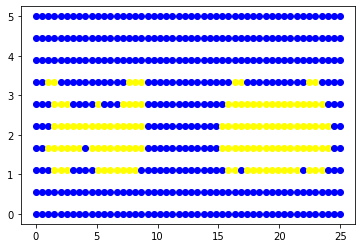

In [29]:
plot_svm(best_gauss)

#### SVM predictions & errors

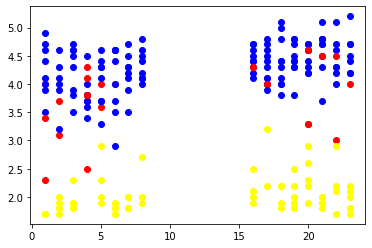

In [30]:
plot_svm_solution(best_gauss, x, y)

#### Real data

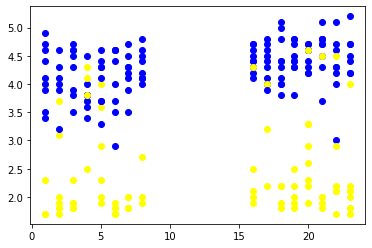

In [31]:
plot_something(x, y)

## Chips

In [32]:
x, y = to_x_y(chip)
y = y.astype(jnp.integer)

In [33]:
best_params = find_hyperparams((x, y), c, (kernels, kernel_args))
best_params

  0%|          | 0/3 [00:00<?, ?it/s]

Kernel: <function linear at 0x7fdc67fc2940>
------Best accuracy:  0.5
Kernel: <function polynomial at 0x7fdc67fc29d0>
------Best accuracy:  0.625
Kernel: <function gaussian at 0x7fdc67fc2a60>
------Best accuracy:  0.6666666666666666
Kernel: <function linear at 0x7fdc67fc2940>
------Best accuracy:  0.5833333333333334
Kernel: <function polynomial at 0x7fdc67fc29d0>
------Best accuracy:  0.75
Kernel: <function gaussian at 0x7fdc67fc2a60>
------Best accuracy:  0.75
Kernel: <function linear at 0x7fdc67fc2940>
------Best accuracy:  0.5833333333333334
Kernel: <function polynomial at 0x7fdc67fc29d0>
------Best accuracy:  0.75
Kernel: <function gaussian at 0x7fdc67fc2a60>
------Best accuracy:  0.75


{<function __main__.linear(_)>: {'accuracy': 0.5833333333333334,
  'kernel_args': None,
  'c': 1},
 <function __main__.polynomial(d=1)>: {'accuracy': 0.75,
  'kernel_args': 5,
  'c': 1},
 <function __main__.gaussian(sigma_squared=1)>: {'accuracy': 0.75,
  'kernel_args': 1,
  'c': 1}}

### Linear

In [35]:
x, y = to_x_y(chip)
best_linear, linear_params = smo(x, y, kernel=linear(_), c=1, steps=1)

In [36]:
f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_linear, x))}'

/tmp/ipykernel_2446884/2966238524.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_linear, x))}'


'Accuracy 0.5084745762711864'

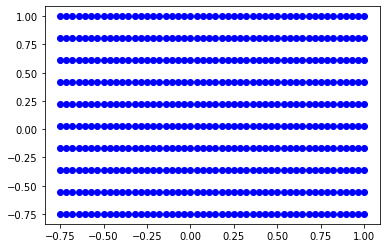

In [37]:
plot_svm(best_linear, min_x=-0.75, min_y=-0.75, max_x=1., max_y=1.)

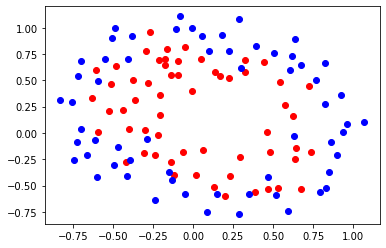

In [38]:
plot_svm_solution(best_linear, x, y)

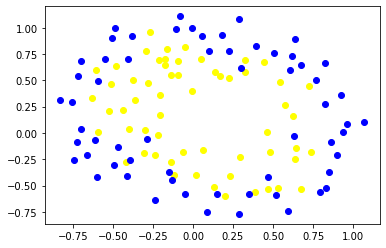

In [39]:
plot_something(x, y)

### Gaussian

In [40]:
x, y = to_x_y(chip)
best_gauss, _ = smo(x, y, kernel=gaussian(1), c=1, steps=1)

In [41]:
f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_gauss, x))}'

/tmp/ipykernel_2446884/1674753320.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_gauss, x))}'


'Accuracy 0.6694915254237288'

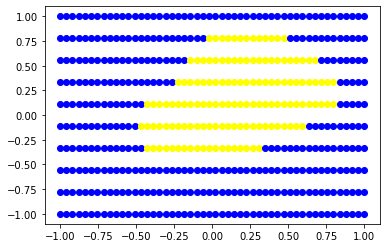

In [42]:
plot_svm(best_gauss, min_x=-1, min_y=-1, max_x=1., max_y=1.)

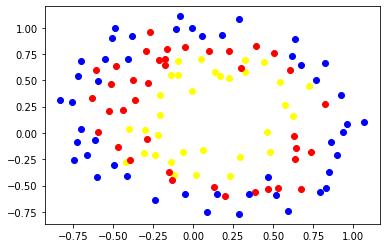

In [43]:
plot_svm_solution(best_gauss, x, y)

### Polynomial

In [44]:
x, y = to_x_y(chip)
best_poly, poly_params = smo(x, y, kernel=polynomial(5), c=1)

In [45]:
f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_poly, x))}'

/tmp/ipykernel_2446884/1926486611.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  f'Accuracy {accuracy(y.astype(jnp.integer), to_class(best_poly, x))}'


'Accuracy 0.5423728813559322'

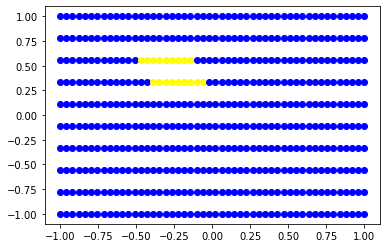

In [46]:
plot_svm(best_poly, min_x=-1, min_y=-1, max_x=1., max_y=1.)

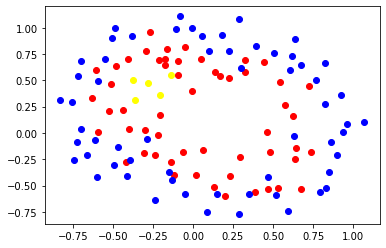

In [47]:
plot_svm_solution(best_poly, x, y)